In [7]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow import keras

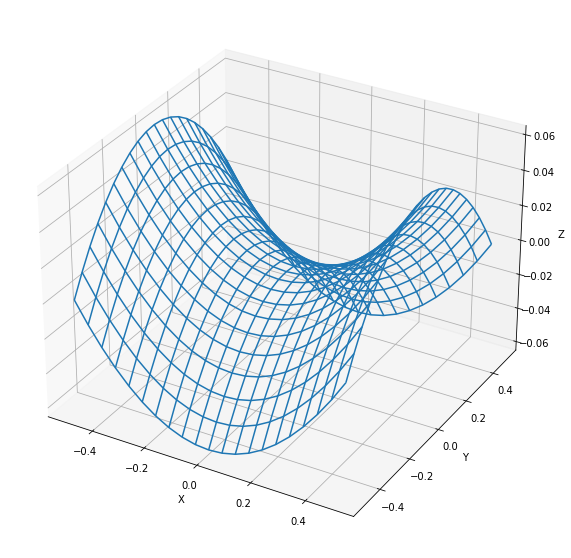

In [81]:
# The function below will be used to generate our training data.

def calculate(x, y):
    a = 2
    b = 2
    l = x**2 / a**2
    r = y**2 / b**2
    return l - r


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-0.5, 0.55, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(calculate(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_wireframe(X, Y, Z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig('function.png')

plt.show()

In [6]:
# 'Real Samples' are samples from the dataset

def generate_real_samples(n=100):
    X1 = np.random.rand(n) - 0.5
    Y1 = np.random.rand(n) - 0.5
    Z1 = calculate(X1, Y1)
    X1 = X1.reshape(n, 1)
    Y1 = Y1.reshape(n, 1)
    Z1 = Z1.reshape(n, 1)
    X = np.hstack((X1, Y1, Z1))
    
    y = np.ones((n, 1))
    return X, y

In [7]:
# 'Latent Points' are inputs to the generator

def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [8]:
# 'Fake Samples' are the output of the generator (fake according to D)

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    
    return X, y

In [2]:
def define_discriminator(n_inputs=3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        35,
        activation='relu',
        kernel_initializer='he_uniform',
        input_dim=n_inputs
    ))
    model.add(keras.layers.Dense(
        25,
        activation='relu',
        kernel_initializer='he_uniform',
    ))
    model.add(keras.layers.Dense(
        1,
        activation='sigmoid',
    ))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [3]:
def define_generator(latent_dim, n_outputs=3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        25,
        activation='relu',
        kernel_initializer='he_uniform',
        input_dim=latent_dim
    ))
    model.add(keras.layers.Dense(
        35,
        activation='relu',
        kernel_initializer='he_uniform',
        input_dim=latent_dim
    ))
    model.add(keras.layers.Dense(
        n_outputs,
        activation='linear',
    ))
    return model

In [4]:
# We define the model as a whole (G and D combined) and set D->trainable to False
# so that only G trains on the gradients produced by D. We explicitly train D
# in the training loop later on.
def define_GAN(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [46]:
from matplotlib import cm

def summarise_performance(epoch, generator, discriminator, latent_dim, n=100, save_fig=False):
    """
        A helper function to analyse and view the performace of the model in training.
    """
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    print(epoch, acc_real, acc_fake)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z)
    #ax.scatter(x_real[:, 0], x_real[:, 1], x_real[:, 2], c='red', marker='o')
    ax.scatter(x_fake[:, 0], x_fake[:, 1], x_fake[:, 2], c='blue', marker='x')
    #cset = ax.scatter(x_real[:, 0], x_real[:, 1], x_real[:, 2], zdir='z', cmap=cm.coolwarm)
    
    #ax.plot_trisurf(x_real[:, 0], x_real[:, 1], x_real[:, 2], cmap='viridis', alpha=0.5, edgecolor='none')
    #ax.plot_trisurf(x_fake[:, 0], x_fake[:, 1], x_fake[:, 2], cmap='coolwarm', alpha=0.8, edgecolor='none')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if save_fig:
        plt.savefig(f'bit_bigger2/{epoch:05}.png')


    plt.show()

In [14]:
def train(g_model, d_model, gan_model,
          latent_dim, n_epochs=100, n_batch=128, n_eval=50
        ):
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # Here we train D first on a real batch and then a fake batch
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        # Here we are only training G as D is frozen (see above)
        gan_model.train_on_batch(x_gan, y_gan)
        if (i+1) % n_eval == 0:
            summarise_performance(i, g_model, d_model, latent_dim)

999 0.8199999928474426 0.46000000834465027


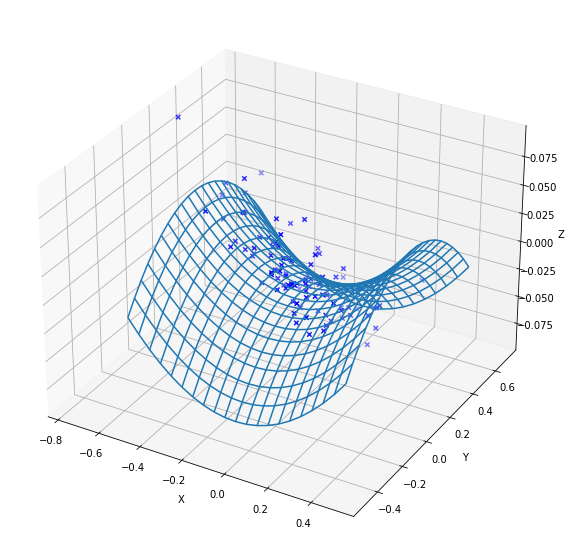

1999 0.4399999976158142 1.0


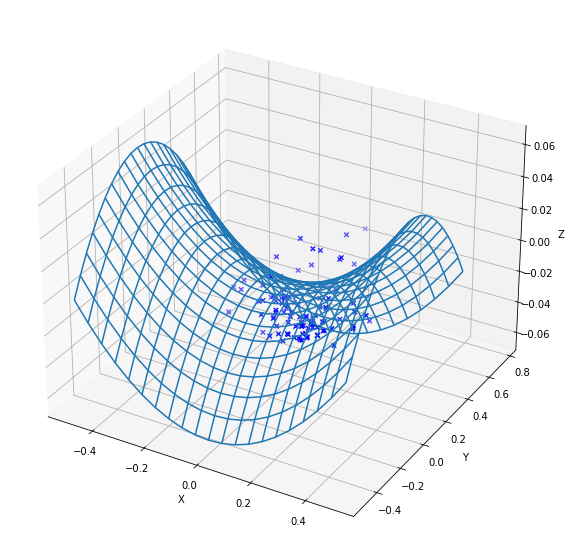

2999 0.7400000095367432 1.0


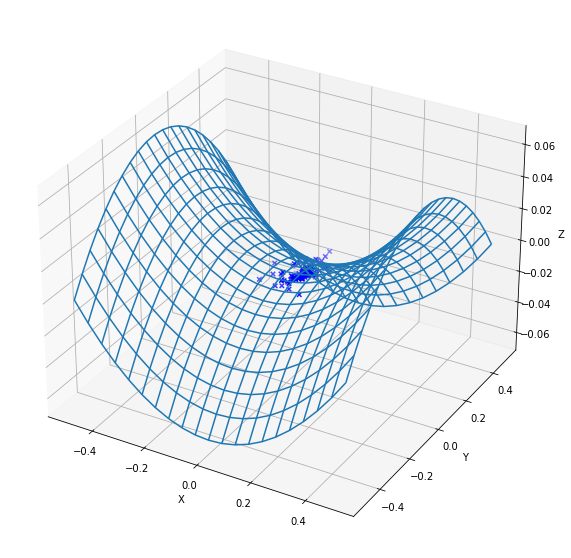

3999 0.7099999785423279 0.20999999344348907


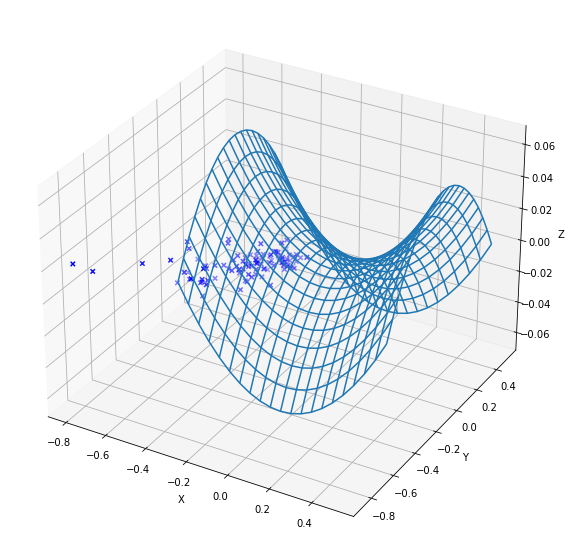

4999 0.41999998688697815 0.75


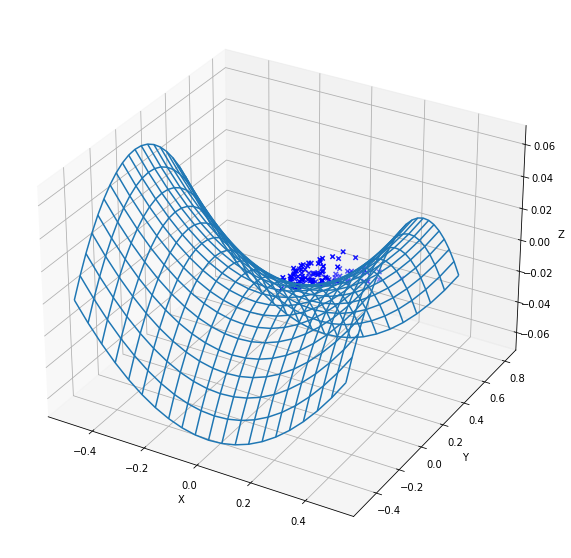

5999 0.3799999952316284 0.3799999952316284


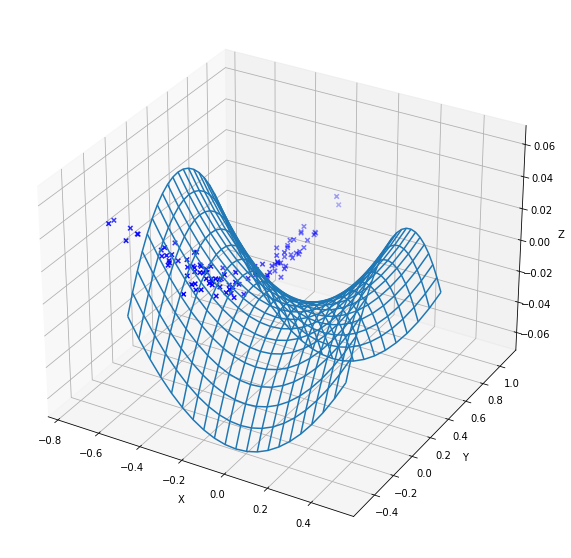

6999 0.4300000071525574 0.9900000095367432


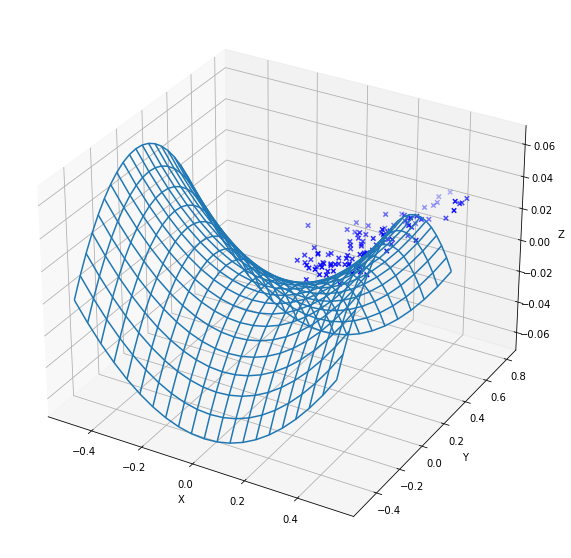

7999 0.46000000834465027 0.5600000023841858


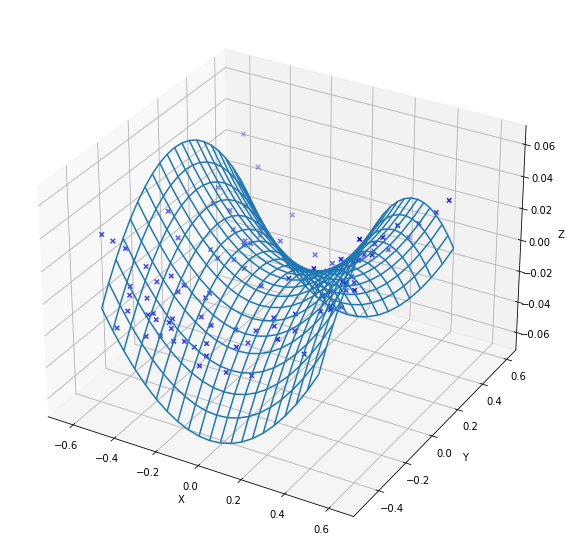

8999 0.36000001430511475 0.699999988079071


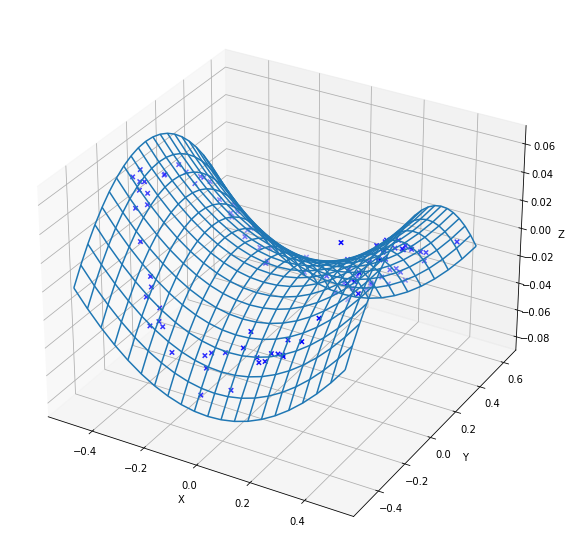

9999 0.5 0.7300000190734863


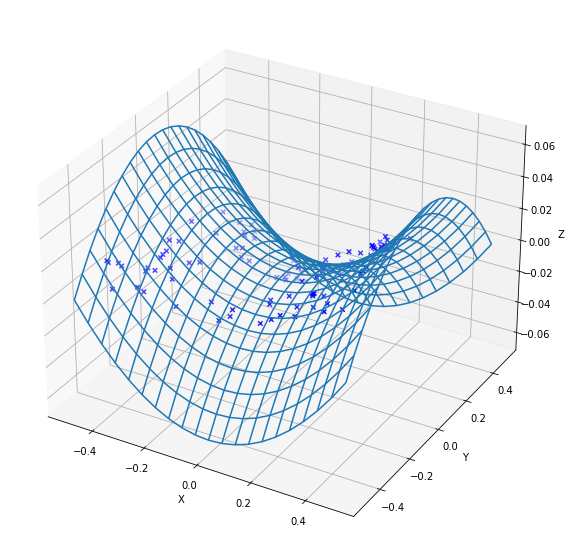

10999 0.2800000011920929 0.8700000047683716


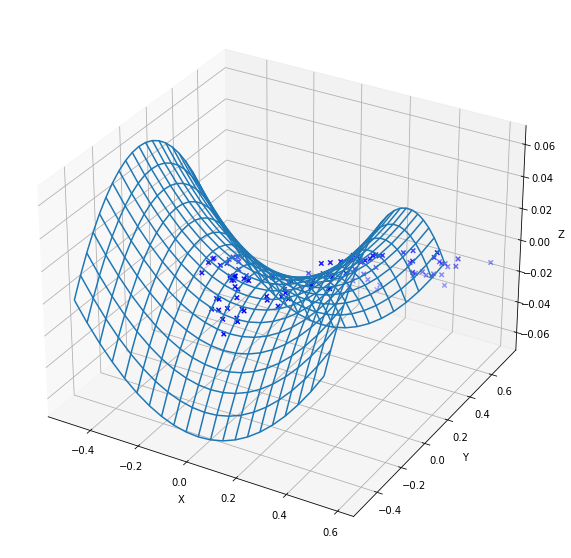

11999 0.3400000035762787 0.6100000143051147


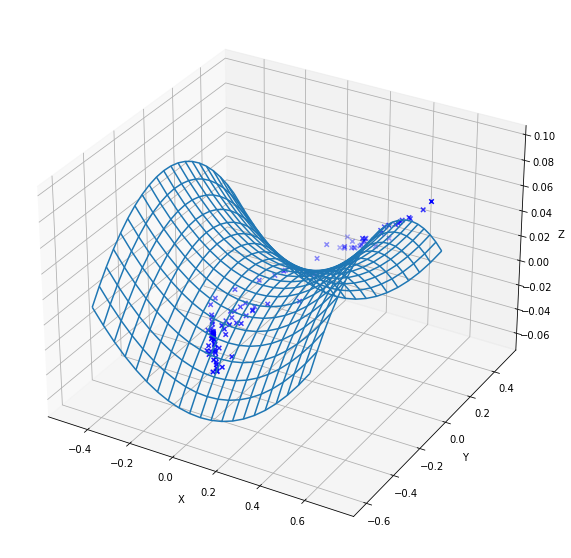

12999 0.3700000047683716 0.3700000047683716


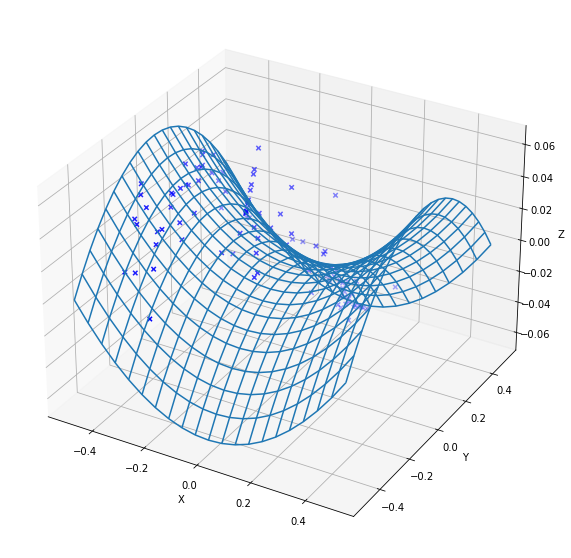

13999 0.5299999713897705 0.6299999952316284


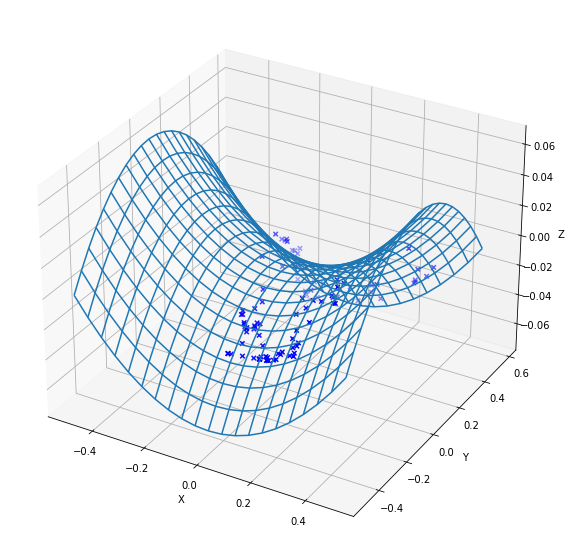

14999 0.6700000166893005 0.5899999737739563


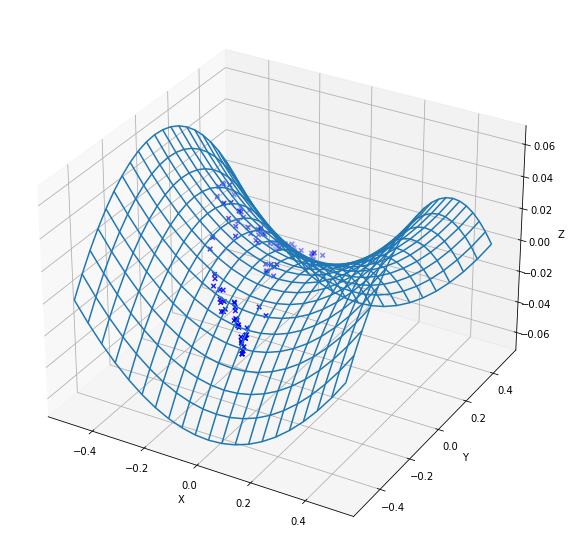

In [18]:
latent_dim = 10
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_GAN(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim, n_epochs=15000, n_eval=1000)

15000 0.6200000047683716 0.6399999856948853


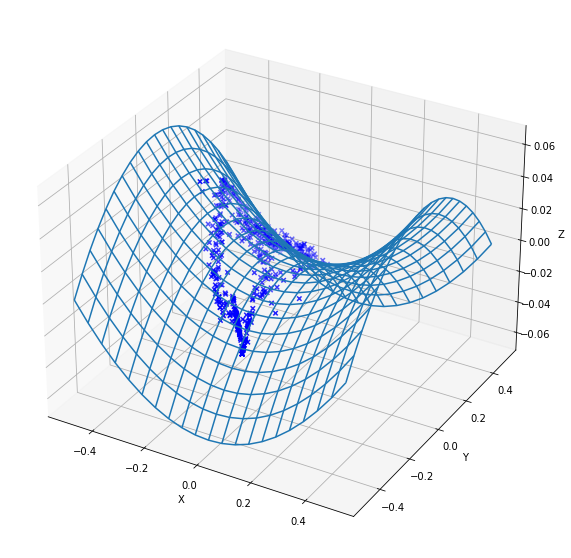

In [19]:
summarise_performance(15000, generator, discriminator, latent_dim, n=500)

In [113]:
def output(name, generator, x_input):
    x_fake = generator.predict(x_input)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z)
    #ax.scatter(x_real[:, 0], x_real[:, 1], x_real[:, 2], c='red', marker='o')
    ax.scatter(x_fake[:, 0], x_fake[:, 1], x_fake[:, 2], c='blue', marker='x')
    #cset = ax.scatter(x_real[:, 0], x_real[:, 1], x_real[:, 2], zdir='z', cmap=cm.coolwarm)
    
    #ax.plot_trisurf(x_real[:, 0], x_real[:, 1], x_real[:, 2], cmap='viridis', alpha=0.5, edgecolor='none')
    #ax.plot_trisurf(x_fake[:, 0], x_fake[:, 1], x_fake[:, 2], cmap='coolwarm', alpha=0.8, edgecolor='none')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    #plt.savefig(f'bit_bigger2/{name:05}.png')
    #plt.savefig('./bit_bigger/training_data.png')
    plt.savefig(f'./bit_bigger2/{name}.png')

    plt.show()
    
    return x_fake

In [8]:
latent_dim = 10
generator = define_generator(latent_dim)
generator.load_weights("generator.h5")

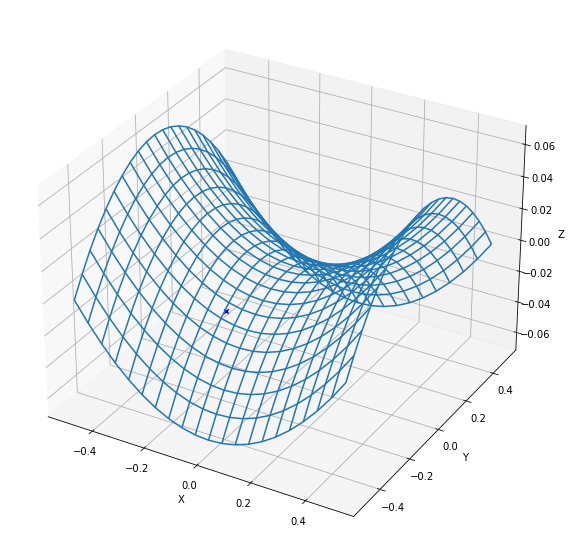

[[-0.75962652 -0.91593046 -0.35008425 -0.0411178  -0.94043401  0.22664192
  -0.41033864  0.09371178 -0.6731295   2.33696267]]
[[-0.08343434 -0.24433902 -0.008375  ]]


In [114]:
input_vec = np.random.randn(latent_dim)
input_vec = input_vec.reshape(1, latent_dim)

output_coords = output('single-point2', generator, input_vec)

print(input_vec)
print(output_coords)

In [105]:
# uniform interpolation between two points in latent space
# https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

In [103]:
#https://medium.com/@pnpsegonne/animating-a-3d-scatterplot-with-matplotlib-ca4b676d4b55

import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

def make_animation(data, title=None, save=False):
    """
    Creates the 3D figure and animates it with the input data.
    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:], c='blue', marker='x') for i in range(data[0].shape[0]) ]
    iterations = len(data)
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    if not title:
        title = "Sample Video"
    ax.set_title(title)
    ax.plot_wireframe(X, Y, Z)
    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                       interval=50, blit=False, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save(f"{title.lower().replace(' ', '-')}.mp4", writer=writer)

    plt.show()

In [93]:
A = np.random.randn(latent_dim)
B = np.random.randn(latent_dim)
points = interpolate_points(A, B, n_steps=80)
coords = [generator.predict(p.reshape(1, latent_dim)) for p in points]

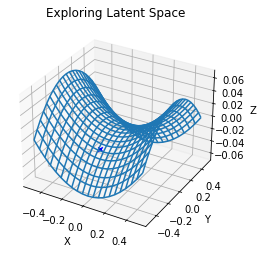

In [104]:
make_animation(coords, title="Exploring Latent Space", save=True)